#Random Forest Racial Image Classification with Reinforcement Learning with Human Feedback

This Random Forest image classification model detects if a person is black or not based on their face.

The model uses Reinforcement Learning with Human Feedback (RLHF) to improve the model with human responses, tuning the model to capture a different racial biases to the given.

##Import Libraries

In [61]:
pip install datasets pandas scikit-learn opencv-python pillow

In [62]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from datasets import load_dataset
from PIL import Image
from skimage.feature import hog
from skimage import exposure
import cv2
from google.colab.patches import cv2_imshow

##Load the Dataset
We will be using the FairFace dataset and get it from HuggingFace

In [63]:
dataset = load_dataset("HuggingFaceM4/FairFace", '0.25')
df = pd.DataFrame(dataset['train'])

In [64]:
print(df.columns)
print(df.head())

Index(['image', 'age', 'gender', 'race', 'service_test'], dtype='object')
                                               image  age  gender  race  \
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...    6       0     0   
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...    4       1     1   
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...    1       1     2   
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...    3       1     1   
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...    3       1     1   

   service_test  
0          True  
1         False  
2         False  
3          True  
4          True  


##Add Label for Black Faces (Total Images: 86744)

In [65]:
df['label'] = df['race'].apply(lambda x: 1 if x == 2 else 0)
print(f"Number of samples after labeling: {len(df)}")

Number of samples after labeling: 86744


##Preprocess the Images
Resize image for processing

In [66]:
def preprocess_image(image):
    image = image.convert('L')  # Convert to grayscale
    image = image.resize((64, 64))  # Resize to 64x64 for better feature extraction
    return np.array(image)

# Apply preprocessing
df['image'] = df['image'].apply(preprocess_image)

# Check the dataset again
print(f"Number of samples after preprocessing: {len(df)}")

Number of samples after preprocessing: 86744


##Split the Dataset
We will use a subset for quicker demonstration purposes

In [67]:
df_subset = df.sample(n= 1000, random_state=42)  # Take a random subset of 1000 samples
X = np.array(df_subset['image'].tolist())
y = np.array(df_subset['label'].tolist())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Confirm the shapes of the datasets
print(f"Training set size: {len(X_train)}, Test set size: {len(X_test)}")
print(f"Shape of an image: {X_train[0].shape}")

Training set size: 800, Test set size: 200
Shape of an image: (64, 64)


##Feature Extraction using skimage HOG
Feature extraction using skimage HOG (Histogram of Oriented Gradients) converts the raw image data into a set of numerical features that can be used by machine learning algorithms for training and prediction.

Summary:
1. Dividing the image into small connected regions called cells.

2. Calculating the gradient direction or edge orientation for the pixels within each cell.

3. Creating a histogram of gradient directions for each cell.

4. Normalizing the histograms across a block of cells to improve invariance to changes in illumination or shadowing.

In [68]:
from skimage.feature import hog
from skimage import exposure

def extract_hog_features(images):
    features = []
    for i, image in enumerate(images):
        if len(image.shape) == 2:  # Ensure the image is grayscale
            image = np.uint8(image)  # Ensure the image is in the correct format
            if image.shape == (64, 64):  # Ensure the image is the expected size
                try:
                    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8),
                                        cells_per_block=(2, 2), visualize=True, multichannel=False)
                    features.append(fd)
                except Exception as e:
                    print(f"Error computing HOG for image at index {i}: {e}")
                    continue
            else:
                print(f"Unexpected image size at index {i}: {image.shape}")
        else:
            print(f"Unexpected image shape at index {i}: {image.shape}")
    return np.array(features)
X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

<ipython-input-68-9d2a9a4b1c1d>:11: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8),


In [69]:
print(f"Shape of HOG features for training set: {X_train_hog.shape}")
print(f"Shape of HOG features for test set: {X_test_hog.shape}")

Shape of HOG features for training set: (800, 1568)
Shape of HOG features for test set: (200, 1568)


##Standardize the Features

In [70]:
scaler = StandardScaler()
X_train_hog = scaler.fit_transform(X_train_hog)
X_test_hog = scaler.transform(X_test_hog)

##Train a Random Forest Model for image classification

In [71]:
model = RandomForestClassifier(n_estimators=10, random_state=42)
model.fit(X_train_hog, y_train)

RandomForestClassifier(n_estimators=10, random_state=42)

##Evaluate the Model

In [72]:
y_pred = model.predict(X_test_hog)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 83.00%


In [73]:
incorrect_predictions = sum(y_pred != y_test)
print(f'Number of incorrect predictions: {incorrect_predictions}')

Number of incorrect predictions: 34


##Collect Human Feedback via CLI

We will get human feedback via CLI. The CLI will prompt an image and ask if the person is black or not.

In [85]:
from google.colab.patches import cv2_imshow
def get_human_feedback(image):
    # Display the image using OpenCV
    cv2_imshow(image)
    cv2.waitKey(1)  # Display the image for a short time

    # Get user input
    feedback = input("Is the person Black? (y/n): ").strip().lower()
    cv2.destroyAllWindows()

    if feedback == 'y':
        return 1
    elif feedback == 'n':
        return 0
    else:
        print("Invalid input. Please enter 'y' or 'n'.")
        return get_human_feedback(image)

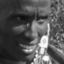

Is the person Black? (y/n): y


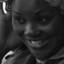

Is the person Black? (y/n): y


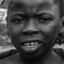

Is the person Black? (y/n): y


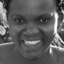

Is the person Black? (y/n): y


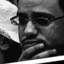

Is the person Black? (y/n): n


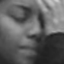

Is the person Black? (y/n): y


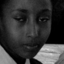

Is the person Black? (y/n): y


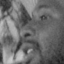

Is the person Black? (y/n): y


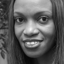

Is the person Black? (y/n): y


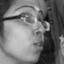

Is the person Black? (y/n): y


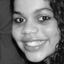

Is the person Black? (y/n): n


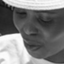

Is the person Black? (y/n): n


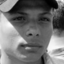

Is the person Black? (y/n): n


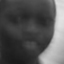

Is the person Black? (y/n): n


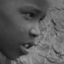

Is the person Black? (y/n): n


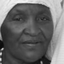

Is the person Black? (y/n): n


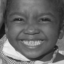

Is the person Black? (y/n): n


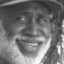

Is the person Black? (y/n): y


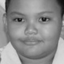

Is the person Black? (y/n): n


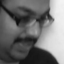

Is the person Black? (y/n): n


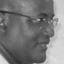

Is the person Black? (y/n): n


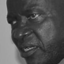

Is the person Black? (y/n): y


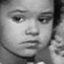

Is the person Black? (y/n): n


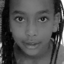

Is the person Black? (y/n): y


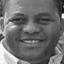

Is the person Black? (y/n): n


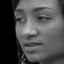

Is the person Black? (y/n): n


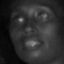

Is the person Black? (y/n): n


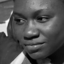

Is the person Black? (y/n): n


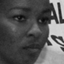

Is the person Black? (y/n): y


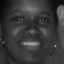

Is the person Black? (y/n): y


In [86]:
def simulate_human_feedback(pred, true_label, image):
    if pred == true_label:
        return 'correct'
    else:
        human_feedback = get_human_feedback(image)
        return 'correct' if human_feedback == true_label else 'incorrect'

# Randomly select 100 incorrect predictions for feedback
incorrect_indices = np.where(y_pred != y_test)[0]
np.random.shuffle(incorrect_indices)
limited_feedback_indices = incorrect_indices[:30]

# Apply human feedback collection to the selected incorrect predictions
feedback = [simulate_human_feedback(y_pred[i], y_test[i], X_test[i]) for i in limited_feedback_indices]

In [87]:
def reward_function(feedback):
    return 1 if feedback == 'correct' else -1

rewards = [reward_function(f) for f in feedback]

##Update the Model Based on Rewards

In [90]:
for i, idx in enumerate(limited_feedback_indices):
    if rewards[i] == -1:
        X_train_hog = np.vstack([X_train_hog, X_test_hog[idx]])
        y_train = np.hstack([y_train, y_test[idx]])
        model.fit(X_train_hog, y_train)

In [91]:
y_pred_updated = model.predict(X_test_hog)
accuracy_updated = accuracy_score(y_test, y_pred_updated)
print(f'Updated Accuracy: {accuracy_updated * 100:.2f}%')

Updated Accuracy: 90.50%


###The model is improved after the human feedback.